In [1]:
import os

from src.utils import get_dataset
from src.vae.mnist_vae import ConditionalVae
import matplotlib.pyplot as plt
from src.impute import impute_cvae_naive
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from src.image_classifier.exq_net_v1 import ExquisiteNetV1
import torch
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# binarize the data
class args:
    def __init__(self):
        self.num_channels = 1
        self.iid = 1
        self.num_classes = 10
        self.num_users = 10
        self.dataset = 'mnist'

training_data, testing_data, user_groups = get_dataset(args())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:07<00:00, 1370075.28it/s]


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 291014.58it/s]


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1641425.76it/s]


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11063024.84it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
  

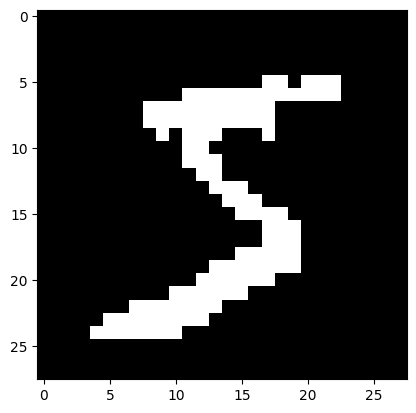

In [3]:
plt.imshow(training_data[0][0][0], cmap='gray')

print(training_data[0][0][0])

In [4]:
model = "cvae"
dataset = "mnist"
batch_size = 32
epochs = 20
learning_rate = 0.001

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epochs}_{learning_rate}.pt"

if os.path.exists(model_path):
    cvae_model = torch.load(model_path)
else:
    cvae = ConditionalVae(dim_encoding=3).to(device)

    # try with model sigma
    cvae_model, vae_loss_li, kl_loss_li, reg_loss_li = cvae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate
    )
    torch.save(cvae_model, model_path)

vl_loss: 24841.130859375
Finished epoch:  1
vl_loss: 47268.71484375
Finished epoch:  2
vl_loss: 69200.6640625
Finished epoch:  3
vl_loss: 89774.8359375
Finished epoch:  4
vl_loss: 110266.640625
Finished epoch:  5
vl_loss: 130459.40625
Finished epoch:  6
vl_loss: 150757.625
Finished epoch:  7
vl_loss: 170486.640625
Finished epoch:  8
vl_loss: 190838.90625
Finished epoch:  9
vl_loss: 210809.921875
Finished epoch:  10
vl_loss: 230636.96875
Finished epoch:  11
vl_loss: 250695.296875
Finished epoch:  12
vl_loss: 270332.25
Finished epoch:  13
vl_loss: 290011.90625
Finished epoch:  14
vl_loss: 309347.15625
Finished epoch:  15
vl_loss: 328808.625
Finished epoch:  16
vl_loss: 348848.59375
Finished epoch:  17
vl_loss: 368308.5625
Finished epoch:  18
vl_loss: 387844.4375
Finished epoch:  19
vl_loss: 406871.21875
Finished epoch:  20


In [5]:
# generate synthetic data
gen_dataset = impute_cvae_naive(k=60000, trained_cvae = cvae_model, initial_dataset = torch.tensor([]))

In [6]:
# train classifier on gen data
model = "exq_v1"
dataset = "mnist"
batch_size = 32
learning_rate = 0.001
epochs = 10

train_loader= DataLoader(gen_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epochs}_{learning_rate}.pt"

classifier = ExquisiteNetV1(class_num=10, img_channels=1).to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

# Number of epochs to train the model
train_losses = []
test_losses = []
f1_scores = []
correct_predictions = 0
total_predictions = 0
for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    pred_labels = []
    actual_labels = []
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = classifier(data)
        pred_labels.append(output.argmax(dim=1))
        actual_labels.append(target)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * data.size(0)

    # Switch to evaluation mode
    classifier.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_pred_labels = []
        test_actual_labels = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            test_pred_labels.append(output.argmax(dim=1))
            test_actual_labels.append(target)
             # Compare with actual classes
            total_predictions += output.argmax(dim=1).size(0)
            # correct_predictions += (predicted == labels).sum().item()
            correct_predictions += (output.argmax(dim=1) == target).sum().item()
            
    # Compute average test loss
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    train_losses.append(train_loss)
    
    # Calculate F1 score for the test data
    test_pred_labels = torch.cat(test_pred_labels).to('cpu').numpy()
    test_actual_labels = torch.cat(test_actual_labels).to('cpu').numpy()
    test_f1_score = f1_score(test_actual_labels, test_pred_labels, average='macro')
    f1_scores.append(test_f1_score)
    accuracy = correct_predictions / total_predictions

    print(f'Accuracy: {accuracy * 100}%')
    print('Epoch: {} \tTraining Loss: {:.6f} \t Test Loss: {:.6f} \tF1 Test Macro: {:.6f}'.format(
        epoch + 1,
        train_loss,
        test_loss,
        test_f1_score
    ))
    
    # torch.save(classifier, model_path)

  0%|          | 0/15 [00:00<?, ?it/s]/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  7%|▋         | 1/15 [00:29<06:47, 29.11s/it]

Accuracy: 87.67%
Epoch: 1 	Training Loss: 0.141749 	 Test Loss: 0.517279 	F1 Test Macro: 0.876555


 13%|█▎        | 2/15 [00:52<05:36, 25.91s/it]

Accuracy: 88.23%
Epoch: 2 	Training Loss: 0.066130 	 Test Loss: 0.580547 	F1 Test Macro: 0.887286


 20%|██        | 3/15 [01:19<05:13, 26.13s/it]

Accuracy: 87.72%
Epoch: 3 	Training Loss: 0.036763 	 Test Loss: 0.636404 	F1 Test Macro: 0.870164


 27%|██▋       | 4/15 [01:44<04:42, 25.65s/it]

Accuracy: 88.2225%
Epoch: 4 	Training Loss: 0.027976 	 Test Loss: 0.618212 	F1 Test Macro: 0.895492


 33%|███▎      | 5/15 [02:13<04:30, 27.06s/it]

Accuracy: 88.32799999999999%
Epoch: 5 	Training Loss: 0.028993 	 Test Loss: 0.694400 	F1 Test Macro: 0.884990


 40%|████      | 6/15 [02:41<04:07, 27.47s/it]

Accuracy: 88.37166666666667%
Epoch: 6 	Training Loss: 0.022105 	 Test Loss: 0.933533 	F1 Test Macro: 0.884851


 47%|████▋     | 7/15 [03:09<03:41, 27.66s/it]

Accuracy: 88.62%
Epoch: 7 	Training Loss: 0.024602 	 Test Loss: 0.863863 	F1 Test Macro: 0.899815


 53%|█████▎    | 8/15 [03:37<03:12, 27.49s/it]

Accuracy: 88.7875%
Epoch: 8 	Training Loss: 0.016904 	 Test Loss: 0.848370 	F1 Test Macro: 0.899899


 60%|██████    | 9/15 [04:06<02:48, 28.16s/it]

Accuracy: 89.21333333333334%
Epoch: 9 	Training Loss: 0.019498 	 Test Loss: 0.444843 	F1 Test Macro: 0.925599


 67%|██████▋   | 10/15 [04:37<02:25, 29.02s/it]

Accuracy: 89.437%
Epoch: 10 	Training Loss: 0.016718 	 Test Loss: 0.480381 	F1 Test Macro: 0.913877


 73%|███████▎  | 11/15 [05:07<01:57, 29.32s/it]

Accuracy: 89.56363636363636%
Epoch: 11 	Training Loss: 0.011807 	 Test Loss: 0.621824 	F1 Test Macro: 0.907634


 80%|████████  | 12/15 [05:36<01:27, 29.17s/it]

Accuracy: 89.51916666666668%
Epoch: 12 	Training Loss: 0.012335 	 Test Loss: 0.592077 	F1 Test Macro: 0.889545


 87%|████████▋ | 13/15 [06:01<00:56, 28.04s/it]

Accuracy: 89.42%
Epoch: 13 	Training Loss: 0.017276 	 Test Loss: 0.820473 	F1 Test Macro: 0.882063


 93%|█████████▎| 14/15 [06:28<00:27, 27.45s/it]

Accuracy: 89.28%
Epoch: 14 	Training Loss: 0.008880 	 Test Loss: 1.100559 	F1 Test Macro: 0.873715


100%|██████████| 15/15 [06:55<00:00, 27.73s/it]

Accuracy: 89.422%
Epoch: 15 	Training Loss: 0.009410 	 Test Loss: 0.599664 	F1 Test Macro: 0.913986


In [7]:
# test classifier with real testing data
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)

        # Pass the data to the model
        outputs = classifier(data)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Compare with actual classes
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100}%')

Accuracy: 91.41%
